In [1]:
from baseline import *
device = "cuda" if torch.cuda.is_available() else "cpu"

FNC
	train      has 39978 rows and shapes (39978, 5).
	validation has  4997 rows and shapes (4997, 5).
	test       has  4997 rows and shapes (4997, 5).
LIAR
	train      has 10240 rows and shapes (10240, 14).
	validation has  1284 rows and shapes (1284, 14).
	test       has  1267 rows and shapes (1267, 14).


In [2]:
FNC_MODEL = "./FNC_model"
FNC_model = torch.load(FNC_MODEL)
FNC_model.eval()

linearRegression(
  (linear1): Linear(in_features=300, out_features=256, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (activation3): ReLU()
  (linear4): Linear(in_features=32, out_features=2, bias=True)
)

In [8]:
# only use LIAR statment vectors (None, 300)
train_df = ds(dataset = "LIAR", type = "train")
train_X = train_df[[i for i in train_df.columns if "vector_" in i]]
train_y = train_df["label"]

val_df = ds(dataset = "LIAR", type = "val")
val_X = val_df[[i for i in val_df.columns if "vector_" in i]]
val_y = val_df["label"]

test_df = ds(dataset = "LIAR", type = "test")
test_X = test_df[[i for i in test_df.columns if "vector_" in i]]
test_y = test_df["label"]

train_X, train_y = torch.tensor(train_X.values), torch.tensor(train_y.values)
train_X, train_y = train_X.to(device), train_y.to(device)

val_X, val_y = torch.tensor(val_X.values), torch.tensor(val_y.values)
val_X, val_y = val_X.to(device), val_y.to(device)

test_X, test_y = torch.tensor(test_X.values), torch.tensor(test_y.values)
test_X, test_y = test_X.to(device), test_y.to(device)

FNC_feature = FNC_model(train_X), FNC_model(val_X), FNC_model(test_X)

train_X = torch.concat([train_X, FNC_feature[0]], 1).detach()
val_X = torch.concat([val_X, FNC_feature[1]], 1).detach()
test_X = torch.concat([test_X, FNC_feature[2]], 1).detach()

train = torch.utils.data.TensorDataset(train_X, train_y)
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)

In [16]:
print(f"FNC model output features shape: {FNC_feature[0].shape}")
print(f"Current X shape: {train_X.shape}")

FNC model output features shape: torch.Size([10240, 2])
Current X shape: torch.Size([10240, 302])


In [20]:
# same training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
model = linearRegression(train_X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = torch.nn.CrossEntropyLoss()

In [21]:
train_loss_records = []
val_loss_records = []
epoches = 30
for epoch in range(epoches):
    for X, y in train_dataloader:
        X = X.to(device).float()
        y = y.to(device)

        pred = model(X)
        loss = criterion(pred.float(), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_records.append(loss.cpu().detach())

    with torch.no_grad():
        pred = model(val_X)
        val_loss = criterion(pred.float(), val_y)
        val_accuracy = accuracy_score(val_y.cpu(), np.argmax(pred.cpu().numpy(),axis=1))
        print(f"""Epoch: {epoch}, train loss: {loss:.4f}, val loss: {val_loss:.4f}
            val accuracy: {val_accuracy:.4f}""")

        val_loss_records.append(val_loss.cpu().detach())

with torch.no_grad():
    test_pred = model(test_X)
    test_y, test_pred = test_y.cpu(), np.argmax(test_pred.cpu().numpy(),axis=1)
    test_accuracy = accuracy_score(test_y, test_pred)
    test_f1 = f1_score(test_y, test_pred)
    print(f"test accuracy: {test_accuracy} | test f1 score: {test_f1}")

Epoch: 0, train loss: 0.6047, val loss: 0.6138
            val accuracy: 0.6729
Epoch: 1, train loss: 0.6157, val loss: 0.6164
            val accuracy: 0.6760
Epoch: 2, train loss: 0.6120, val loss: 0.5992
            val accuracy: 0.6760
Epoch: 3, train loss: 0.6533, val loss: 0.6043
            val accuracy: 0.6807
Epoch: 4, train loss: 0.6277, val loss: 0.6171
            val accuracy: 0.6581
Epoch: 5, train loss: 0.7383, val loss: 0.5976
            val accuracy: 0.6807
Epoch: 6, train loss: 0.5960, val loss: 0.5944
            val accuracy: 0.6885
Epoch: 7, train loss: 0.6487, val loss: 0.5999
            val accuracy: 0.6807
Epoch: 8, train loss: 0.6165, val loss: 0.6093
            val accuracy: 0.6752
Epoch: 9, train loss: 0.6584, val loss: 0.6263
            val accuracy: 0.6433
Epoch: 10, train loss: 0.5172, val loss: 0.6273
            val accuracy: 0.6433
Epoch: 11, train loss: 0.5949, val loss: 0.6097
            val accuracy: 0.6807
Epoch: 12, train loss: 0.5077, val los

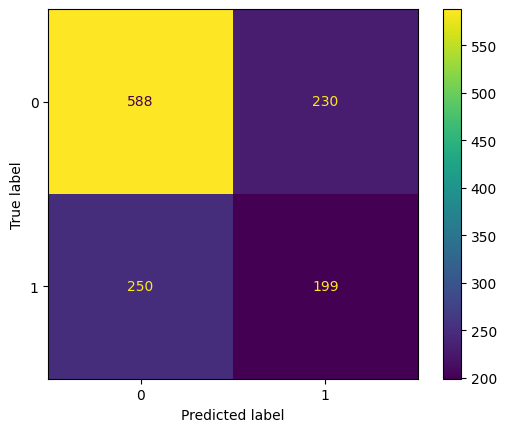

In [22]:
cm = confusion_matrix(test_y, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig("./plots/cm_FNC_feature.png")

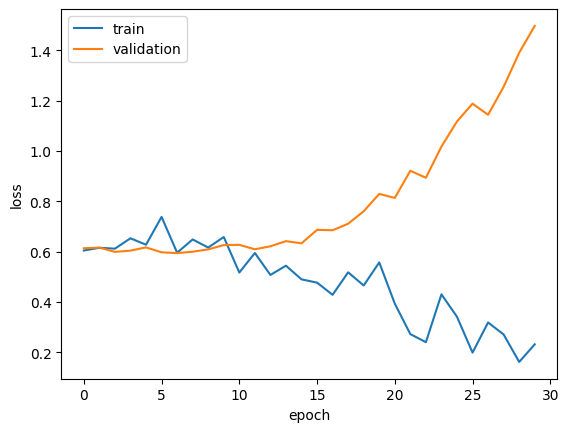

In [24]:
plt.plot(range(len(train_loss_records)), train_loss_records, label = "train")
plt.plot(range(len(val_loss_records)), val_loss_records, label = "validation")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./plots/loss_FNC_feature.png')
plt.legend(['train',"validation"])
plt.show()